# AdEase Time Series Forecasting

## Introduction

AdEase is a digital advertising company focused on helping businesses optimize ad placements by forecasting page views across various Wikipedia pages. The provided dataset contains daily view counts for 145k Wikipedia pages over a period of 550 days. The objective is to forecast future views to assist clients in strategically placing ads on pages that are likely to receive high traffic.

The data includes multiple languages, access types, and origins, allowing an analysis of ad performance across different regions and platforms. Time series forecasting methods such as ARIMA, SARIMAX, and Facebook Prophet will be used to develop predictive models that optimize ad placement.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape)
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

## Loading the Dataset



In [ ]:
data = pd.read_csv('train_1.csv')
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
data.shape

(122739, 551)

In [ ]:
data.dtypes

,0
Page,object
2015-07-01,float64
2015-07-02,float64
2015-07-03,float64
2015-07-04,float64
...,...
2016-12-27,float64
2016-12-28,float64
2016-12-29,float64
2016-12-30,float64


## Loading Exogenous Campaign Data

The `Exog_Campaign_eng` dataset is loaded to understand the impact of significant campaigns or events on page views.

In [ ]:
exog_campaign = pd.read_csv('Exog_Campaign_eng', delimiter=',')
exog_campaign.head(2)

,Exog
0,0
1,0


In [ ]:
exog_campaign.value_counts()

,count
Exog,
0,496
1,54


## Extracting Information from the Page Column

The `Page` column is split into four new columns: `Title`, `Language`, `Access_Type`, and `Access_Origin` to extract key information such as the article title, language, access type, and access origin.


In [ ]:
data[['Title', 'Language', 'Access_Type', 'Access_Origin']] = data['Page'].str.extract(r'^(.*?)_(.*?)\.wikipedia\.org_(.*?)_(.*)$')
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Language,Access_Type,Access_Origin
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh,all-access,spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,11.0,27.0,13.0,36.0,10.0,52,Hz_I_Love_You_zh,all-access,spider


## Reshaping the Dataset and Converting Date Format

The dataset is reshaped using the `melt` function to create a long format, where each row corresponds to a specific page, date, and the number of views. The `Date` column is then converted into a datetime object for further analysis.


In [ ]:
data = pd.melt(data, id_vars=['Page', 'Title', 'Language', 'Access_Type', 'Access_Origin'],
                       var_name='Date', value_name='Views')

# Converting the 'Date' column to a datetime object
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Page,Title,Language,Access_Type,Access_Origin,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh,all-access,spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,zh,all-access,spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,3C,zh,all-access,spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,4minute,zh,all-access,spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52,Hz_I_Love_You_zh,all-access,spider,2015-07-01,NaN


In [ ]:
data.shape

(67506450, 7)

In [ ]:
data['Date'].nunique()

550

## Top 5 Wikipedia Pages by Total Views

A bar plot is generated to display the top 5 Wikipedia pages based on the total number of views across the dataset. The pages are sorted in descending order of total views.


<ipython-input-12-7be14033f3e0>:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


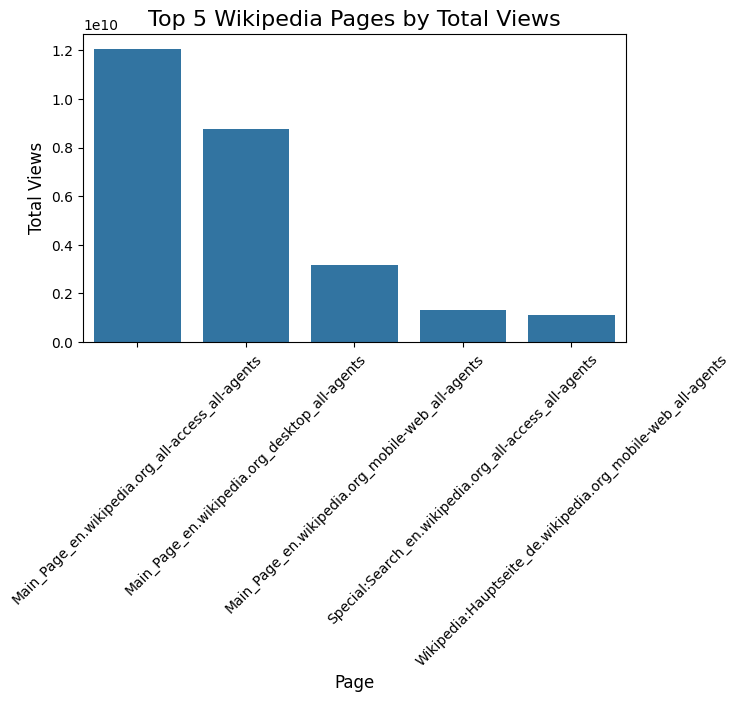

In [ ]:
top5_pages = data.groupby('Page')['Views'].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(7,4))
sns.barplot(x=top5_pages .index, y=top5_pages .values)
plt.title('Top 5 Wikipedia Pages by Total Views', fontsize=16)
plt.xlabel('Page', fontsize=12)
plt.ylabel('Total Views', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Top 5 by Mean Views for Different Attributes

Bar plots are generated to display the top 5 Wikipedia pages based on the mean views for each attribute: `Title`, `Language`, `Access_Type`, and `Access_Origin`. Each plot shows the pages sorted in descending order of mean views for the respective attribute.


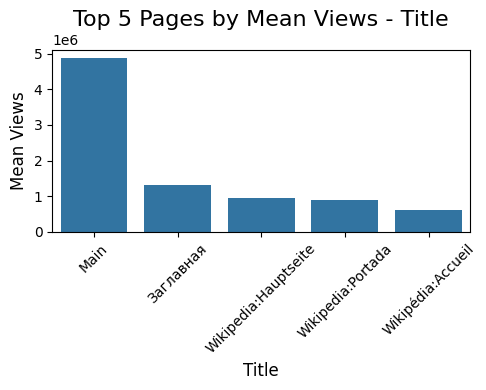

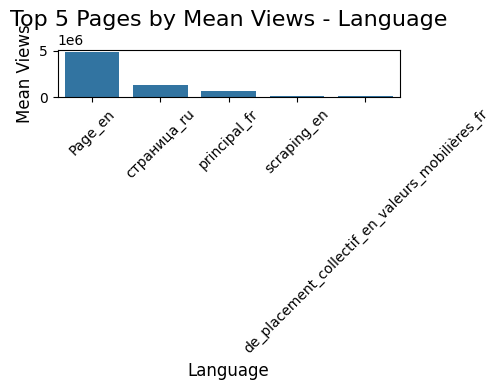

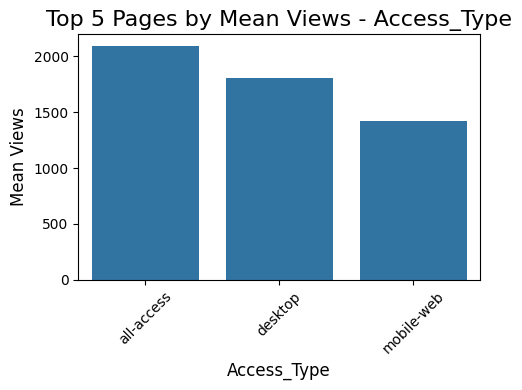

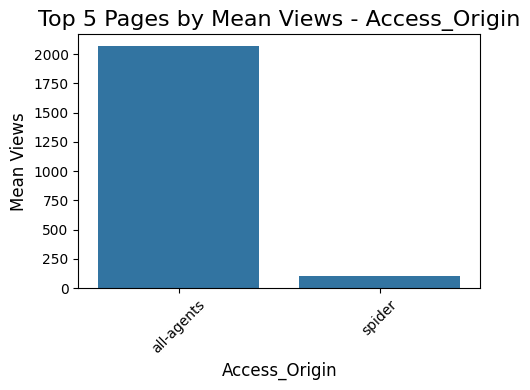

In [ ]:
column = ['Title', 'Language', 'Access_Type', 'Access_Origin']

for i in column:

    top5_pages = data.groupby(i)['Views'].mean().sort_values(ascending=False).head(5)

    plt.figure(figsize=(5,4))
    sns.barplot(x=top5_pages.index, y=top5_pages.values)


    plt.title(f'Top 5 Pages by Mean Views - {i}', fontsize=16)
    plt.xlabel(i, fontsize=12)
    plt.ylabel('Mean Views', fontsize=12)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

## Analyzing and Forecasting the Most Viewed Page

The dataset is filtered to focus on the Wikipedia page with the highest total views. This specific page will be used for detailed analysis and forecasting.


In [ ]:
df = data.groupby('Page')['Views'].sum().sort_values(ascending=False).head(1)

df = data[data['Page']== df.index[0]]

In [ ]:
df.head()

,Page,Title,Language,Access_Type,Access_Origin,Date,Views
38573,Main_Page_en.wikipedia.org_all-access_all-agents,Main,Page_en,all-access,all-agents,2015-07-01,20381245.0
161312,Main_Page_en.wikipedia.org_all-access_all-agents,Main,Page_en,all-access,all-agents,2015-07-02,20752194.0
284051,Main_Page_en.wikipedia.org_all-access_all-agents,Main,Page_en,all-access,all-agents,2015-07-03,19573967.0
406790,Main_Page_en.wikipedia.org_all-access_all-agents,Main,Page_en,all-access,all-agents,2015-07-04,20439645.0
529529,Main_Page_en.wikipedia.org_all-access_all-agents,Main,Page_en,all-access,all-agents,2015-07-05,20772109.0


## Preparing the Dataset for Time Series Analysis

The index of the dataset is set to the `Date` column, and unnecessary columns are dropped to prepare the data for time series analysis. The cleaned dataset now focuses on the views indexed by date.


In [ ]:
df.index = df['Date']
df=df.drop(columns=['Page', 'Title', 'Language', 'Access_Type', 'Access_Origin','Date'])
df.head()

,Views
Date,
2015-07-01,20381245.0
2015-07-02,20752194.0
2015-07-03,19573967.0
2015-07-04,20439645.0
2015-07-05,20772109.0


## Handling Missing Values through Interpolation

Missing values in the `Views` column are addressed using linear interpolation.


In [ ]:
df['Views'] = df['Views'].interpolate(method='linear')

## Capping Outliers in the Views Data

The `Views` column is adjusted to cap outliers by clipping values to the 2nd and 98th percentiles. This helps in mitigating the influence of extreme values on the analysis and forecasting models.


In [ ]:
df['Views'] = df['Views'].clip(upper=df['Views'].quantile(0.98),lower=df['Views'].quantile(0.02))

## Visualizing Views Over Time



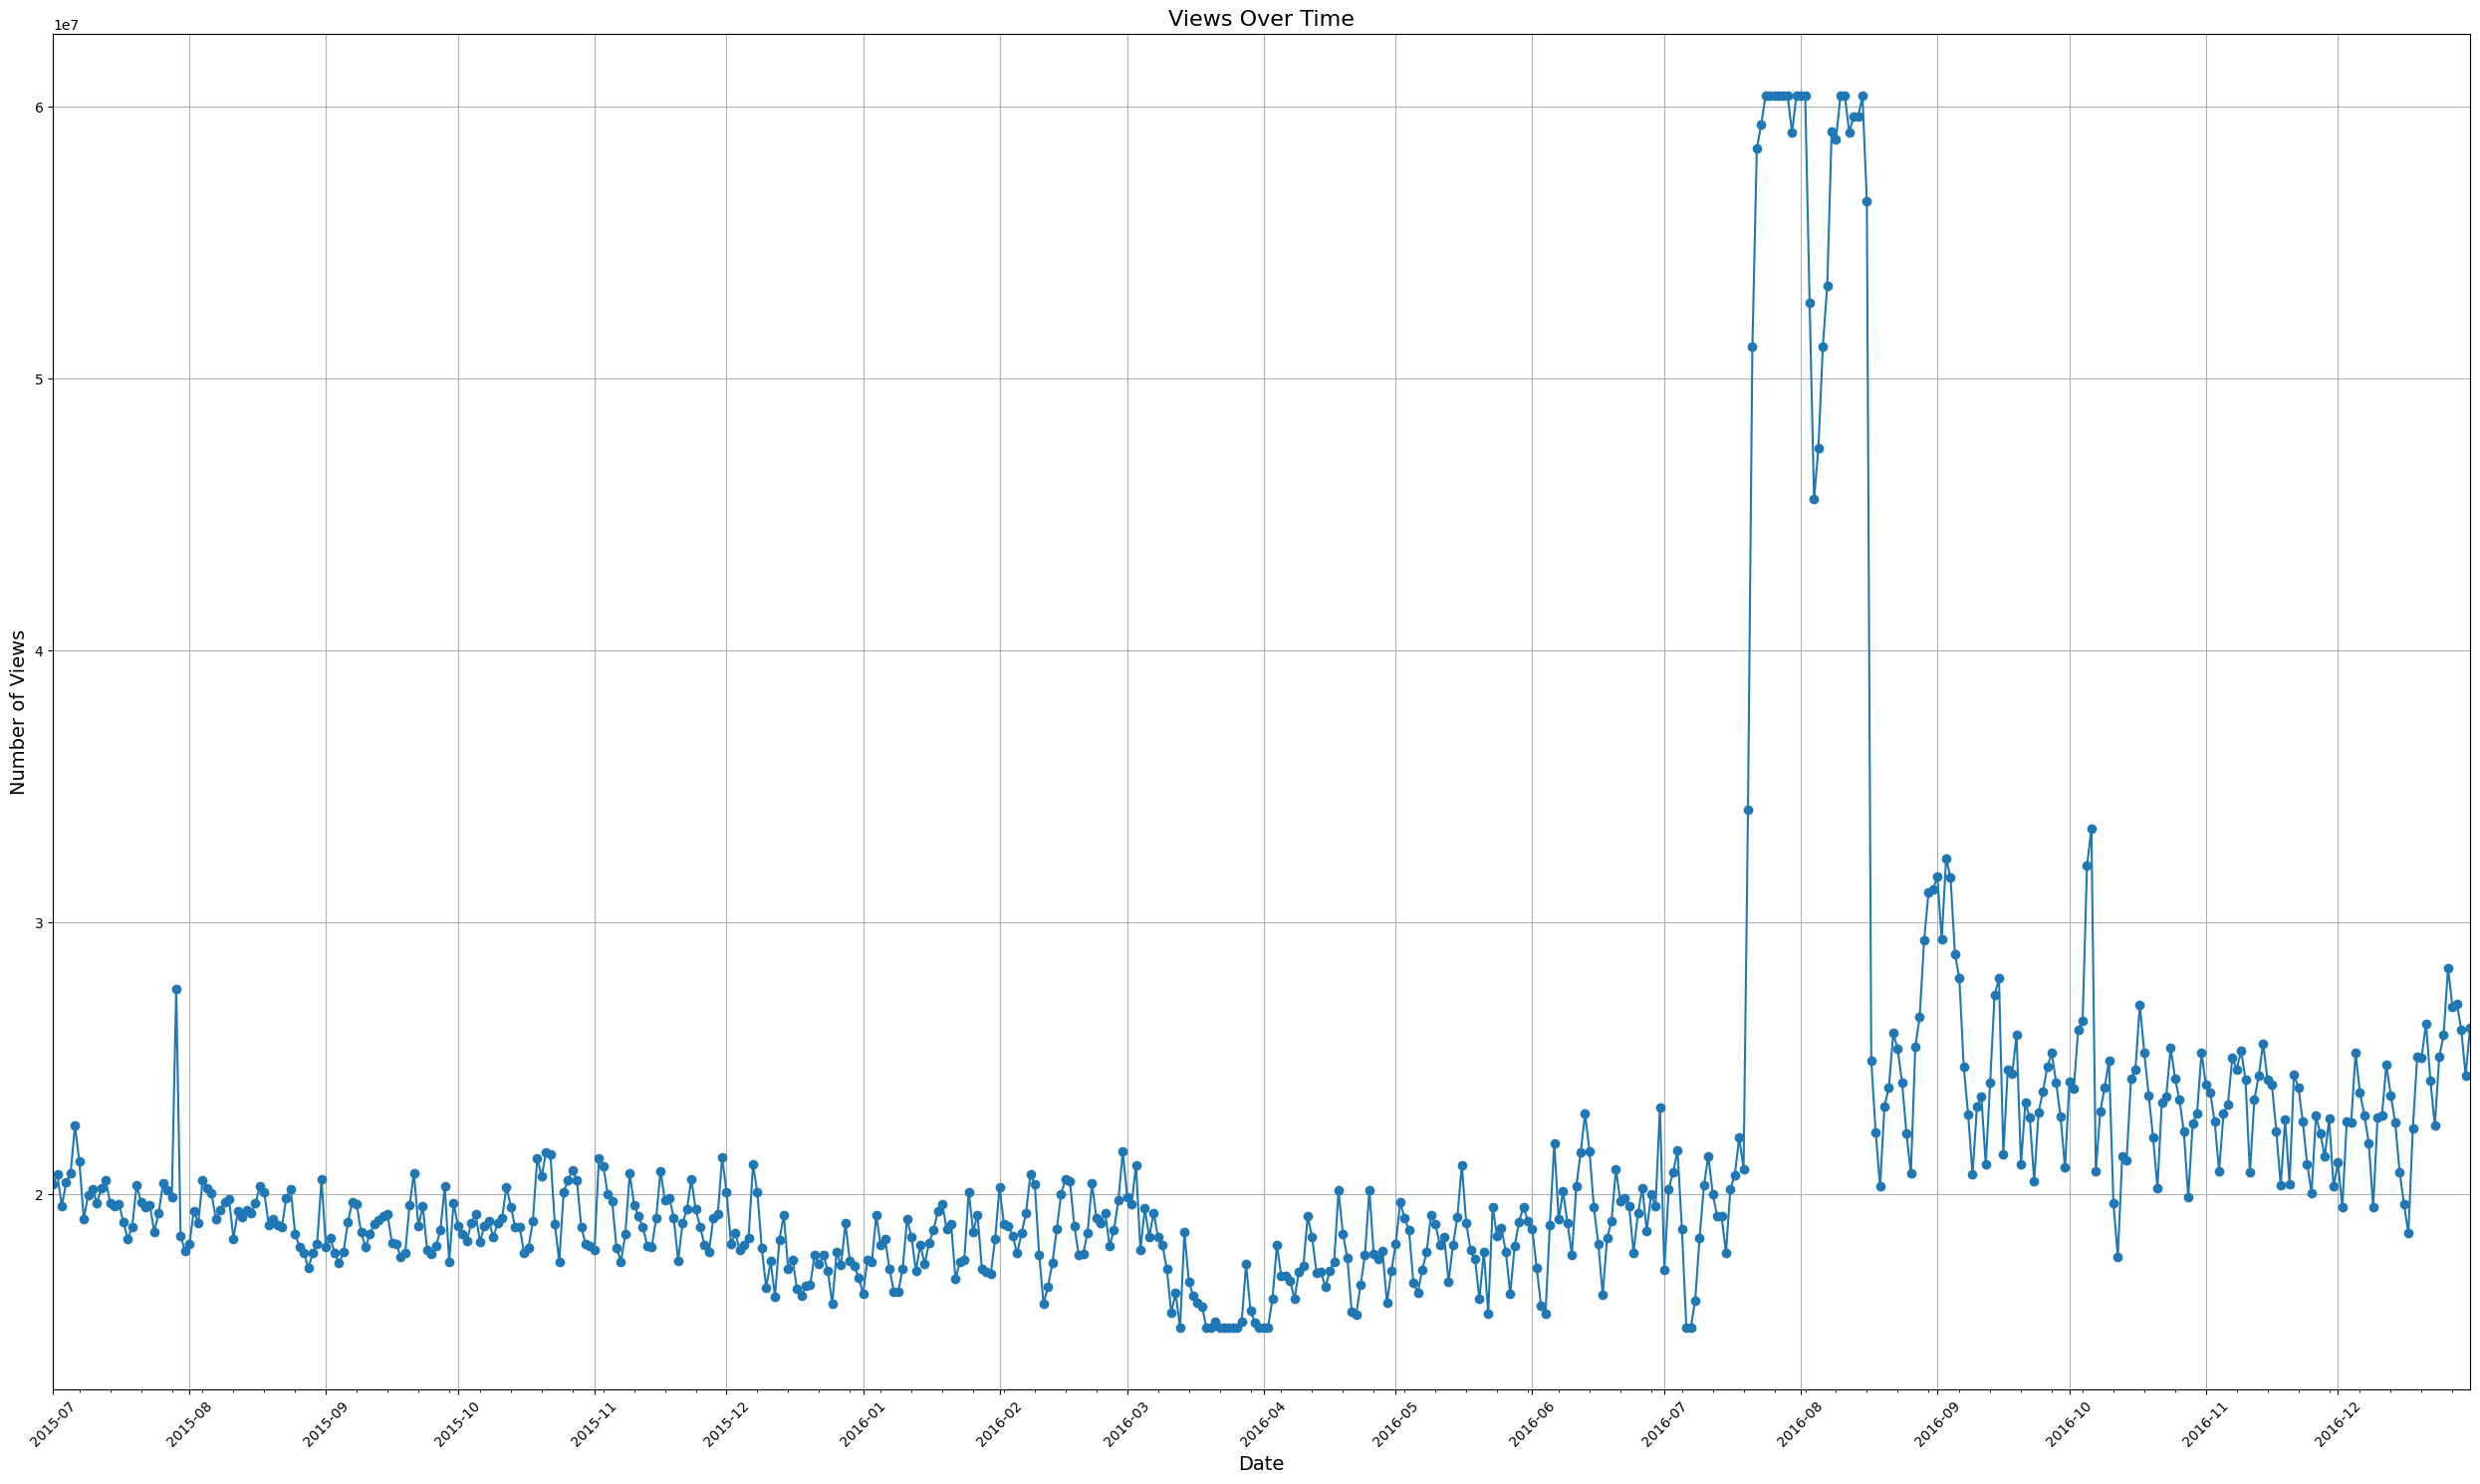

In [ ]:
plt.figure(figsize=(25, 15))
df['Views'].plot(style='-o')

plt.title('Views Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Views', fontsize=14)

# Formatting x-axis to show year and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Set format to 'YYYY-MM'
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator())  # Set minor ticks to weeks (optional)


plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Performance Metrics Function

In [ ]:
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

# Splitting the Dataset into Training and Testing Sets

The dataset is split into training and testing sets, with the training set containing all data points except for the last 12 entries, which are reserved for testing.


In [ ]:
train = df.loc[df.index < df.index[-12]].copy()
test = df.loc[df.index >= df.index[-12]].copy()
print(train.shape,test.shape)

(538, 1) (12, 1)


In [ ]:
train.head()

,Views
Date,
2015-07-01,20381245.0
2015-07-02,20752194.0
2015-07-03,19573967.0
2015-07-04,20439645.0
2015-07-05,20772109.0


## Decomposing the Time Series

The time series data of the training set is decomposed into its seasonal, trend, and residual components using additive decomposition.


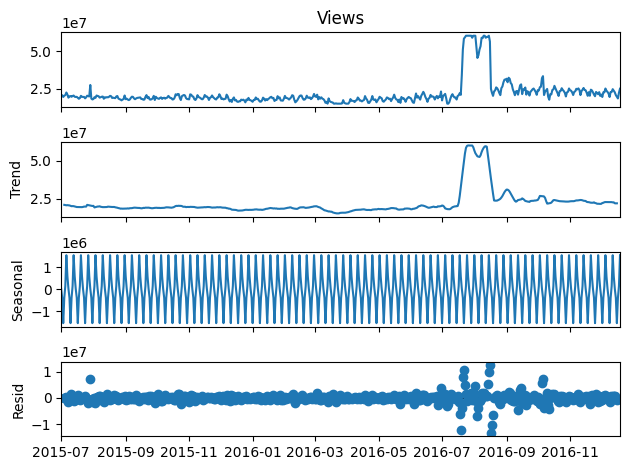

In [ ]:
model = sm.tsa.seasonal_decompose(train['Views'], model='additive')
model.plot()
plt.show()

## Partial Autocorrelation Function (PACF) Plot

The Partial Autocorrelation Function (PACF) is plotted for the training set's views data. This plot helps identify the lagged relationships in the time series, which are essential for determining the order of the AR (AutoRegressive) component in

<Figure size 1200x600 with 0 Axes>

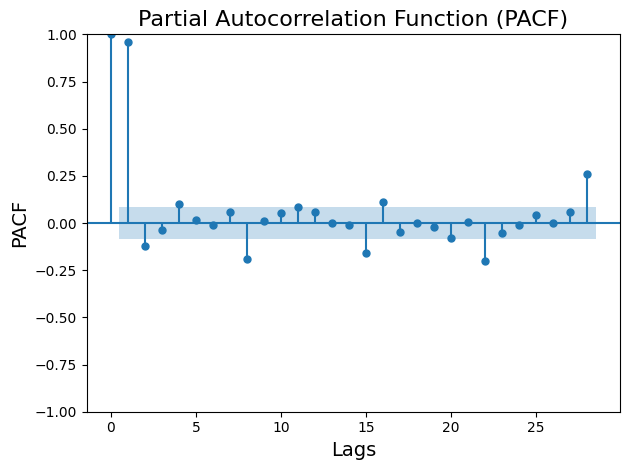

In [ ]:
plt.figure(figsize=(12, 6))
plot_pacf(train['Views'])

plt.title('Partial Autocorrelation Function (PACF)', fontsize=16)
plt.xlabel('Lags', fontsize=14)
plt.ylabel('PACF', fontsize=14)
plt.tight_layout()
plt.show()

## Fitting the Triple  Exponential Smoothing Model

The training dataset is converted to a daily frequency, and an Exponential Smoothing model is fitted with additive trend and seasonal components.


In [ ]:
train = train.asfreq('D')
# Fiting the model with the Exponential Smoothing
model = sm.tsa.ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=4).fit(smoothing_level=1/8)
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,Views,No. Observations:,538
Model:,ExponentialSmoothing,SSE,10020213009372250.000
Optimized:,True,AIC,16454.871
Trend:,Additive,BIC,16489.174
Seasonal:,Additive,AICC,16455.288
Seasonal Periods:,4,Date:,"Fri, 18 Oct 2024"
Box-Cox:,False,Time:,06:14:35
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1250000,alpha,False
smoothing_trend,0.0050000,beta,True


<Axes: xlabel='Date'>

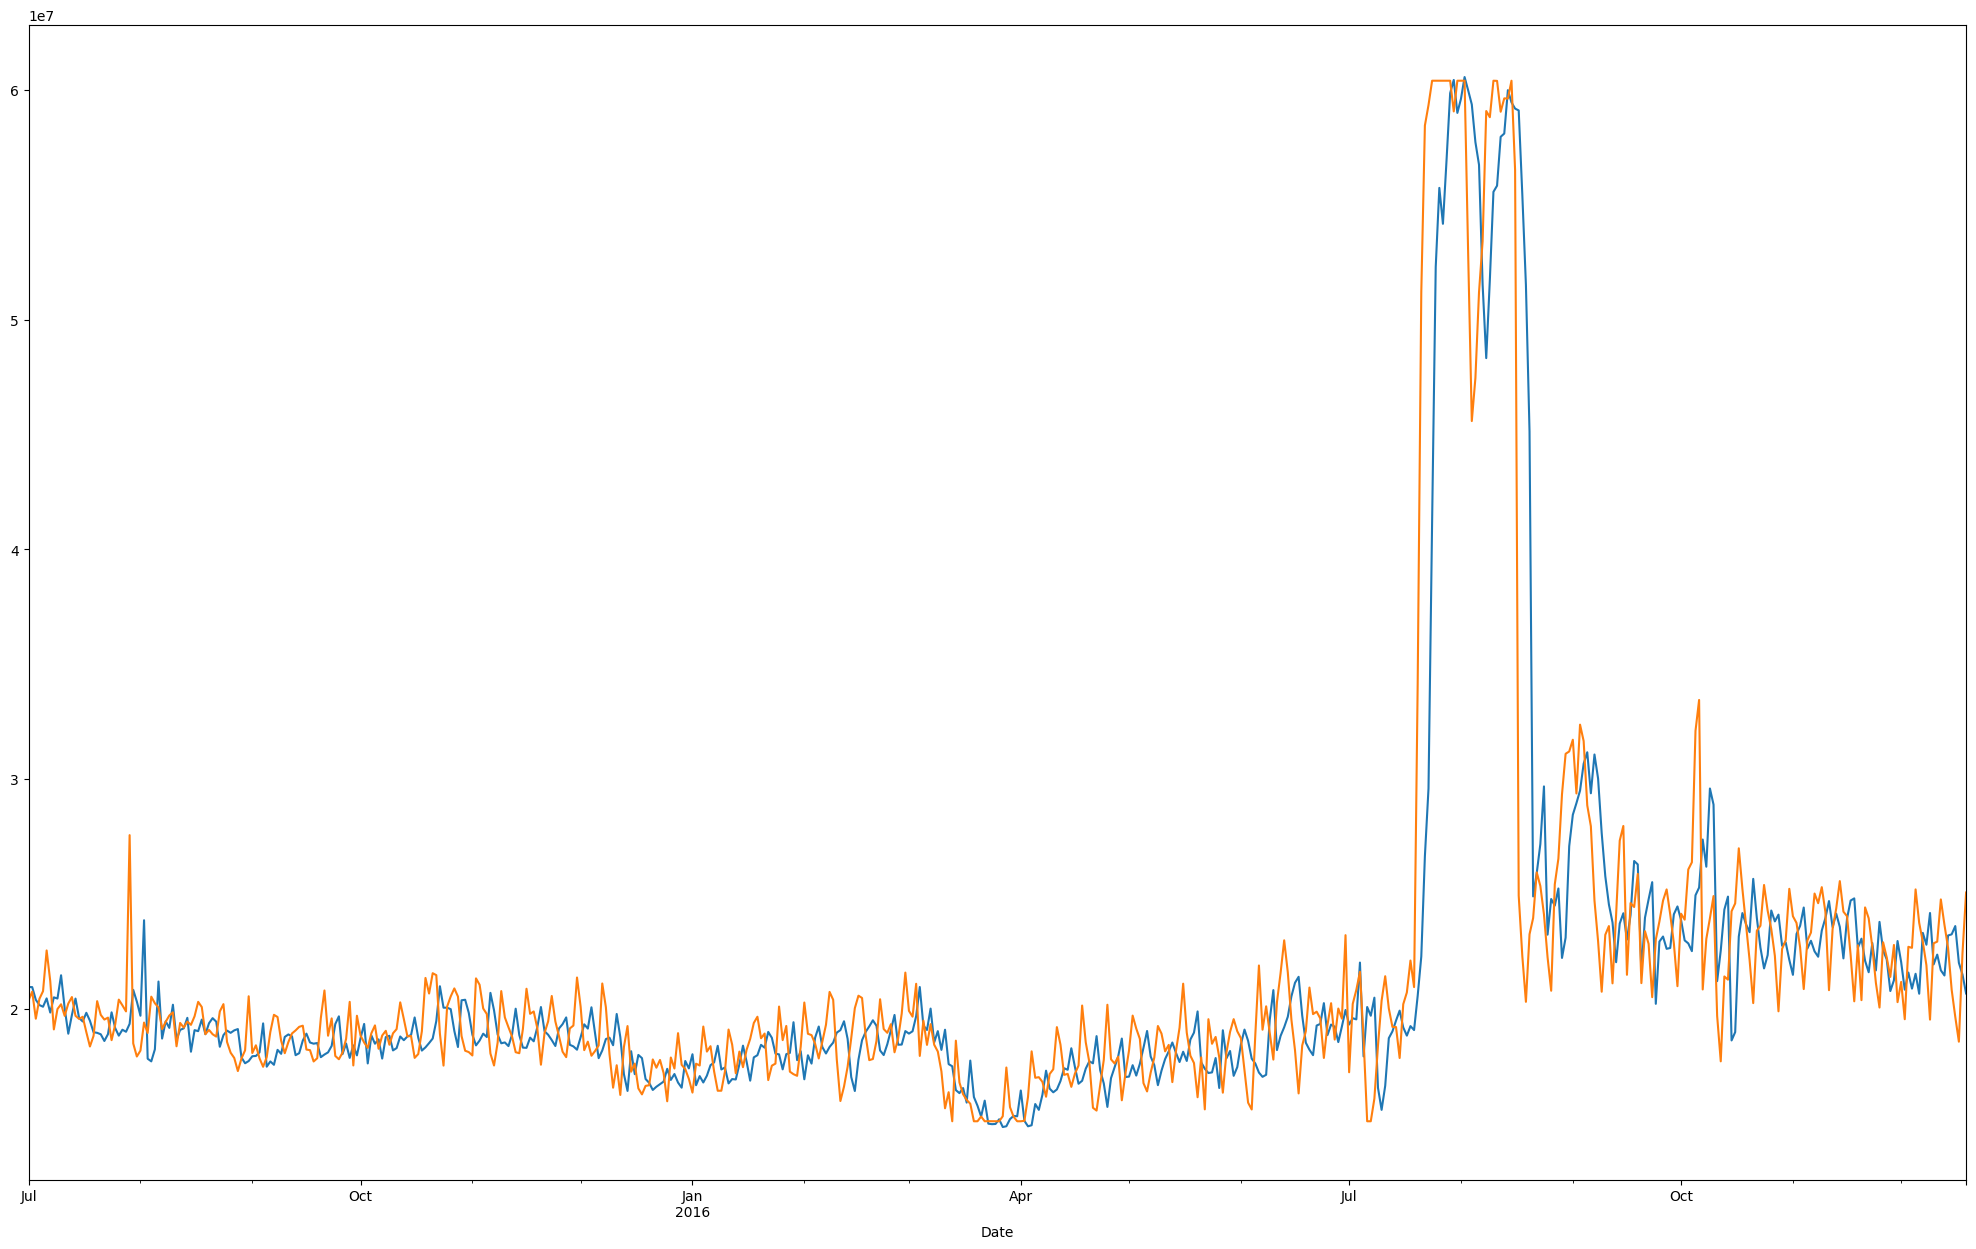

In [ ]:
plt.figure(figsize=(25, 15))
model.fittedvalues.plot()
train['Views'].plot()

##Forecasting with Exponential Smoothing Model

An Exponential Smoothing model is fitted to the training set's views data with additive trend and seasonal components. The model is used to forecast the next 12 steps, and the predictions are plotted alongside the actual values from the test set. Performance metrics, including MAE, RMSE, and MAPE, are calculated to evaluate the accuracy of the forecasts, with the results indicating a MAE of 4,212,303.891, an RMSE of 4,331,684.701, and a MAPE of 0.164.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


MAE : 4212303.891
RMSE : 4331684.701
MAPE: 0.164


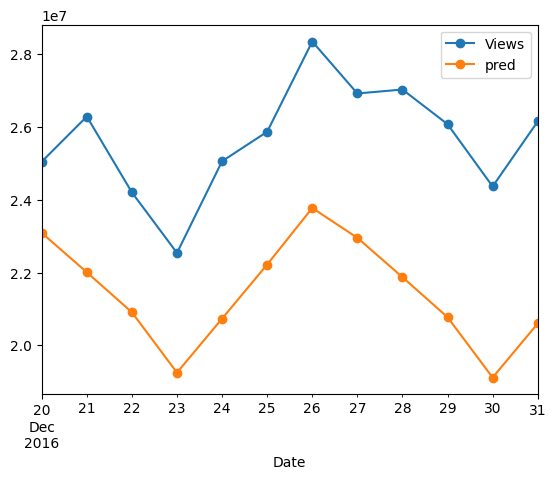

In [ ]:
model = sm.tsa.ExponentialSmoothing(train['Views'], trend='add', seasonal='add').fit(smoothing_level=1/(2*4))
test['pred'] = model.forecast(steps=12)
test.plot(style='-o')
performance(test['Views'], test['pred'])

## Augmented Dickey-Fuller (ADF) Test for Stationarity

The `adf_test` function is defined to perform the Augmented Dickey-Fuller test on the dataset to check for stationarity. The function prints whether the sequence is stationary based on the p-value from the test. In this case, the test results indicate that the training set's views data is not stationary.


In [ ]:
def adf_test(dataset):
   pvalue = sm.tsa.stattools.adfuller(dataset)[1]
   if pvalue <= 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')


In [ ]:
adf_test(train['Views'])

Sequence is not stationary


## Adding Exogenous Variables to the Training and Testing Sets

In [ ]:
exog_campaign.index

RangeIndex(start=0, stop=550, step=1)

In [ ]:
train['Exog_Campaign'] = exog_campaign.iloc[:-12].values  # First part of exog_campaign to train
test['Exog_Campaign'] = exog_campaign.iloc[-12:].values

## SARIMAX Model Fitting and Forecasting

A SARIMAX model is fitted to the training dataset with the `Exog_Campaign` variable included as an exogenous input. The model incorporates seasonal effects with a periodicity of 4. Forecasting is performed for the length of the test dataset, and the predicted values along with confidence intervals are plotted. The plot visually represents the training and testing datasets, the forecasted values, and their uncertainty. The forecast results are also printed for further analysis.


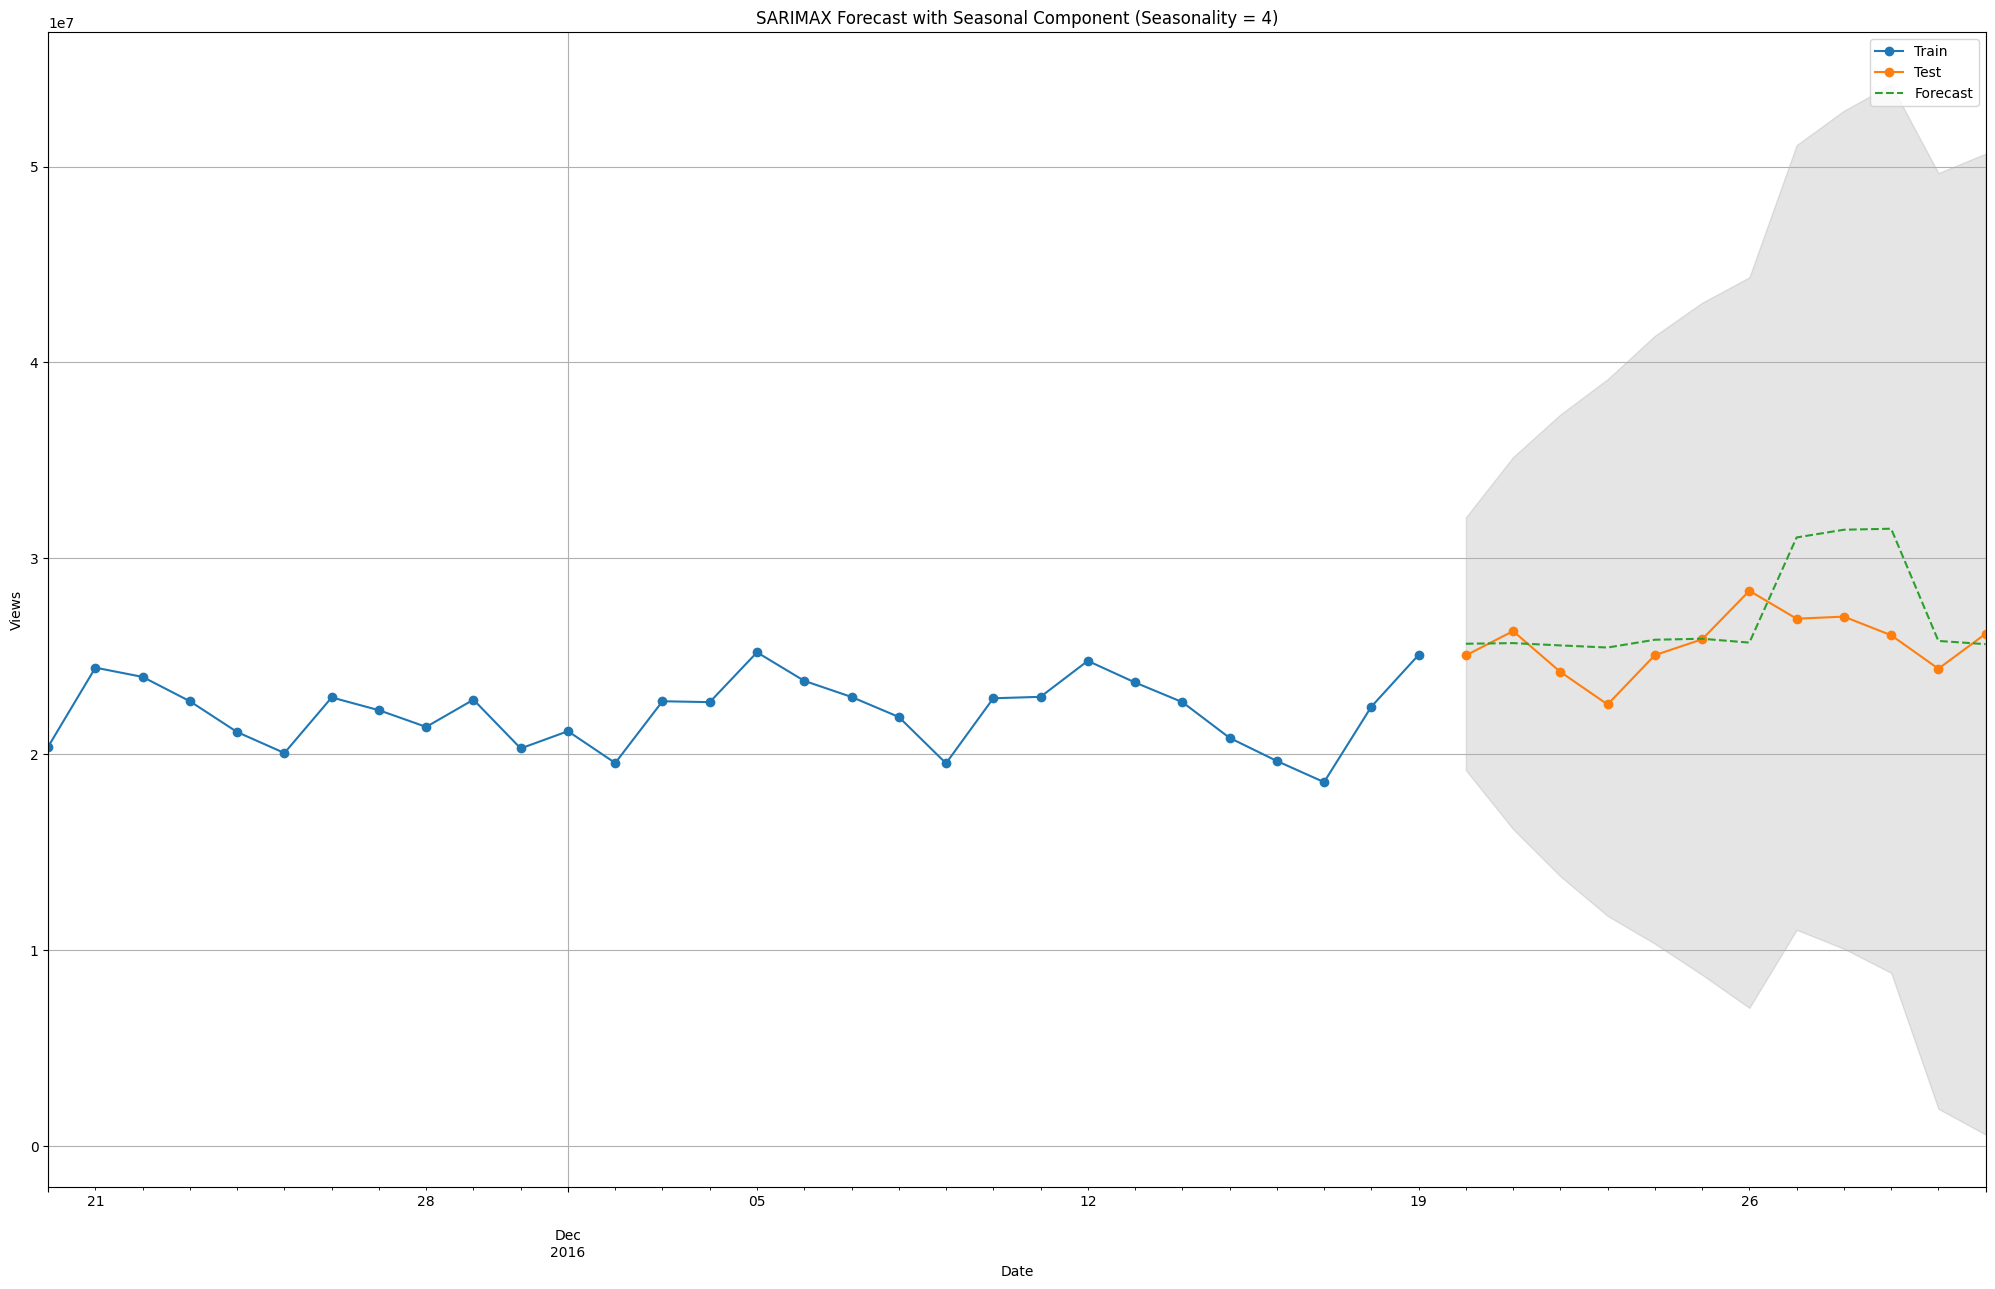

2016-12-20    2.563949e+07
2016-12-21    2.567206e+07
2016-12-22    2.555404e+07
2016-12-23    2.544570e+07
2016-12-24    2.584404e+07
2016-12-25    2.589444e+07
2016-12-26    2.569791e+07
2016-12-27    3.106651e+07
2016-12-28    3.146142e+07
2016-12-29    3.151217e+07
2016-12-30    2.578278e+07
2016-12-31    2.561899e+07
Freq: D, Name: predicted_mean, dtype: float64


In [ ]:
endog = train['Views']
exog_train = train[['Exog_Campaign']]
exog_test = test[['Exog_Campaign']]

# SARIMAX model - Seasonality every 4 points (i.e., weekly seasonality)
model = sm.tsa.SARIMAX(endog, exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4)).fit()

# Forecasting
forecast = model.get_forecast(steps=len(test), exog=exog_test)
predicted_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plotting
plt.figure(figsize=(25,15))
train['Views'].tail(30).plot(label='Train', style='-o')
test['Views'].plot(label='Test', style='-o')
predicted_mean.plot(label='Forecast', style='--')
plt.fill_between(predicted_mean.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='gray', alpha=0.2)
plt.title('SARIMAX Forecast with Seasonal Component (Seasonality = 4)')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.grid(True)
plt.show()

# Print forecast results
print(predicted_mean)

## Calculating Mean Absolute Percentage Error (MAPE)

The Mean Absolute Percentage Error (MAPE) is calculated to evaluate the accuracy of the SARIMAX model's forecasts. The MAPE value is printed, indicating the percentage error between the predicted and actual views in the test dataset, which is reported as 8.03%.


In [ ]:
# MAPE
mape = np.mean(np.abs((test['Views'] - predicted_mean) / test['Views'])) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 8.03%


## Forecasting with Facebook Prophet

The dataset is prepared for forecasting using the Facebook Prophet model. The training data is reset and renamed for compatibility with Prophet's requirements. An external regressor (`Exog_Campaign`) is added to the model, which is then fitted to the data. A future dataframe is created for making predictions, incorporating the external regressor.

After predicting, the results are plotted to visualize the forecast. The Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) are calculated and printed to evaluate the model's accuracy, with the MAPE reported as well.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpguqv67ds/nxdtrsvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpguqv67ds/9yp2iape.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52558', 'data', 'file=/tmp/tmpguqv67ds/nxdtrsvx.json', 'init=/tmp/tmpguqv67ds/9yp2iape.json', 'output', 'file=/tmp/tmpguqv67ds/prophet_modeltkgg9r_q/prophet_model-20241018061439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:14:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-35-d97681fe63fa>:45: Futu

Index(['Exog'], dtype='object')
            ds Date  Exog_Campaign
0   2015-07-01  NaT            NaN
1   2015-07-02  NaT            NaN
2   2015-07-03  NaT            NaN
3   2015-07-04  NaT            NaN
4   2015-07-05  NaT            NaN
..         ...  ...            ...
545 2016-12-27  NaT            NaN
546 2016-12-28  NaT            NaN
547 2016-12-29  NaT            NaN
548 2016-12-30  NaT            NaN
549 2016-12-31  NaT            NaN

[550 rows x 3 columns]


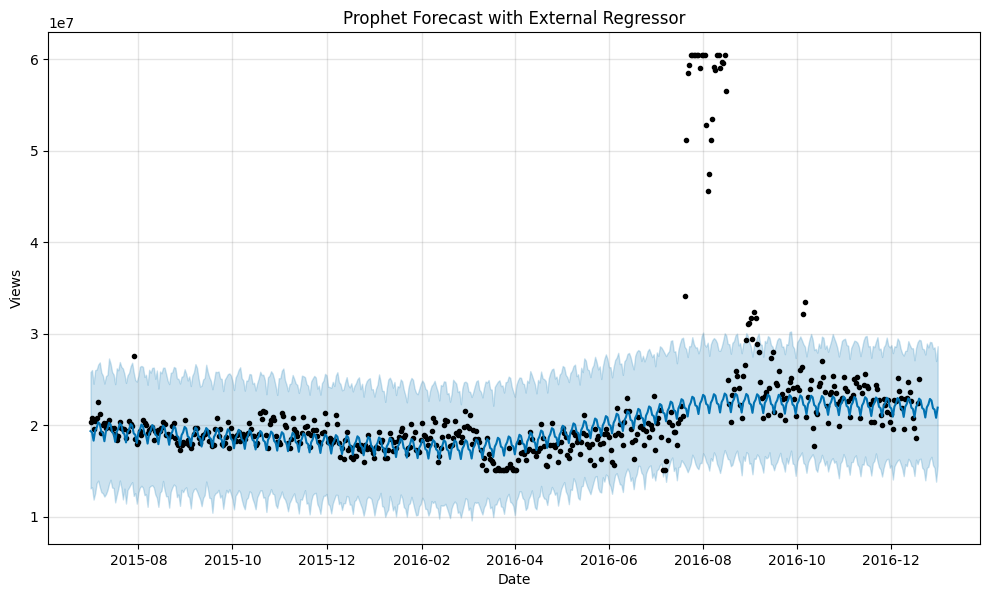

Mean Absolute Error (MAE): 3722178.9369297116
Mean Absolute Percentage Error (MAPE): 14.33%


In [ ]:
df_prophet = train.reset_index()[['Date', 'Views', 'Exog_Campaign']]
df_prophet.columns = ['ds', 'y', 'Exog_Campaign']

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

model = Prophet()
model.add_regressor('Exog_Campaign')
model.fit(df_prophet)

future = model.make_future_dataframe(periods=len(test))
print(exog_campaign.columns)
exog_campaign.reset_index(drop=False, inplace=True)

if len(exog_campaign.columns) == 4:
    exog_campaign.columns = ['Index', 'Date', 'Exog_Campaign', 'Other_Column']
elif len(exog_campaign.columns) == 2:
    exog_campaign.columns = ['Date', 'Exog_Campaign']
else:
    print(f"Unexpected number of columns: {len(exog_campaign.columns)}")

exog_campaign['Date'] = pd.to_datetime(exog_campaign['Date'])

future = future.merge(exog_campaign, left_on='ds', right_on='Date', how='left')
print(future[future['Exog_Campaign'].isnull()])

future['Exog_Campaign'].fillna(0, inplace=True)

future.drop(columns=['Date'], inplace=True)

forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('Prophet Forecast with External Regressor')
plt.xlabel('Date')
plt.ylabel('Views')
plt.show()

predicted_values = forecast['yhat'].tail(len(test)).values  # Get the predicted values for the test set
mae = mean_absolute_error(test['Views'], predicted_values)
print(f'Mean Absolute Error (MAE): {mae}')

mape = np.mean(np.abs((test['Views'] - predicted_values) / test['Views'])) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


# Conclusion

This project focused on analyzing and forecasting Wikipedia page views to optimize ad placements for clients at AdEase. The exploratory data analysis provided insights into view patterns, while various time series forecasting models, including SARIMAX and Facebook Prophet, were implemented to predict future views.

The SARIMAX model, enhanced with exogenous variables, delivered a Mean Absolute Percentage Error (MAPE) of 8.03%, indicating satisfactory accuracy. Meanwhile, the Prophet model incorporated external regressors effectively and offered comparable results.

Overall, the findings suggest that both modeling approaches can be utilized to forecast page views reliably, providing valuable information for clients to enhance their advertising strategies.
